In [0]:
from scipy.io import mmread
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Cell lines: 
# K526 - E123
# GM12878 - E116
# H1 (H1-ESC) - E003


# Expression counts (19795, 2)
K562_rna = pd.read_csv('drive/My Drive/COMS4995_Final/scRNA-seq/E123.expr.csv', sep = ',', names = ("GeneID", "count"))
GM_rna = pd.read_csv('drive/My Drive/COMS4995_Final/scRNA-seq/E116.expr.csv', sep = ',', names = ("GeneID", "count"))
#H1_rna = pd.read_csv('drive/My Drive/COMS4995_Final/scRNA-seq/E003.expr.csv', sep = ',', names = ("GeneID", "count"))

In [0]:
# ATAC-counts and annotations
gm_annots = pd.read_csv('drive/My Drive/COMS4995_FinalProject/data/Bulk/GM_ATAC_annots_bulk.csv', sep = ',', header = 0, index_col = 0)
#h1_annots = pd.read_csv('drive/My Drive/COMS4995_Final/bATAC-seq/H1_ATAC_annots.csv', sep = ',', header = 0, index_col = 0)
k562_annots = pd.read_csv('drive/My Drive/COMS4995_FinalProject/data/Bulk/K562_ATAC_annots_bulk.csv', sep = ',', header = 0, index_col = 0)

gm_counts = pd.read_csv('drive/My Drive/COMS4995_FinalProject/data/Bulk/GM_ATAC_counts_bulk.csv', sep = ',', header = 0, index_col = 0)
#h1_counts = pd.read_csv('drive/My Drive/COMS4995_Final/bATAC-seq/H1_ATAC_counts.csv', sep = ',', header = 0, index_col = 0)
k562_counts = pd.read_csv('drive/My Drive/COMS4995_FinalProject/data/Bulk/K562_ATAC_counts_bulk.csv', sep = ',', header = 0, index_col = 0)

In [9]:
k562_annots

,peaks,annotation,geneStart,geneEnd,ENSEMBL
1,chr1:10035-10326,Promoter (1-2kb),11874,14409,ENSG00000223972
6,chr1:629818-630080,Distal Intergenic,621096,622034,ENSG00000284733
7,chr1:633889-634167,Distal Intergenic,621096,622034,ENSG00000284733
8,chr1:778470-779331,Exon,763178,794826,ENSG00000228794
9,chr1:826949-827724,Distal Intergenic,803451,812182,ENSG00000230368
...,...,...,...,...,...
71688,chrY:56734662-56734923,Distal Intergenic,59100457,59115123,ENSG00000168939
71689,chrY:56742602-56742840,Distal Intergenic,59100457,59115123,ENSG00000168939
71690,chrY:56763388-56763654,Distal Intergenic,59100457,59115123,ENSG00000168939
71691,chrY:56842179-56842500,Distal Intergenic,59100457,59115123,ENSG00000168939


I think the ATAC genes and RNAseq genes should be the same? But I'm not 100% sure.   

In [0]:
# Want matrix M (Genes x Annotation Type)
# either we do a sparse matrix (geneA_1, geneA_2, ..., geneA_n where n refers to the number of peaks in that gene?)
# or do we want to condense it down into annotation counts per gene

# genes in each cell type must be the same

'''
Number of ATAC-seq genes not in mRNA gene list:

    GM12878: 2143 / 15357 genes 
       K562: 2104 / 15312 genes
         H1: 2377 / 17150 genes

ATAC-seq genes unique to cell lines:

    GM12878: 
              2933 : K562
              1324 : H1
               644 : Both
       K562:
              1888 : GM12878
              1641 : H1
              943  : Both
         H1:
              3479 : K562
              3135 : GM12878
              1190 : Both 
'''

krna_genes = list(np.array(K562_rna)[:, 0])
gmrna_genes = list(np.array(GM_rna)[:, 0])
#h1rna_genes = list(np.array(H1_rna)[:, 0])

gm_genes = list(np.unique(gm_annots.values[:, 4]))
#h1_genes = list(np.unique(h1_annots.values[:, 4]))
k562_genes = list(np.unique(k562_annots.values[:, 4]))

In [11]:
# Need to remove non-RNAseq genes from ATAC seq
def remove(atac, rna):
  genes = []

  j = 0
  for i in atac:
    if i not in rna:
      genes.append(i)
      j += 1

  atac = list(set(atac) - set(genes))

  return atac

#h1_genes = remove(h1_genes, h1rna_genes)
gm_genes = remove(gm_genes, gmrna_genes)
k562_genes = remove(k562_genes, krna_genes)

# ATAC genes common to all cell types
#h1_gm = list(set(h1_genes).intersection(gm_genes))
#h1_k562 = list(set(h1_genes).intersection(k562_genes))
# gm_k562 = list(set(gm_genes).intersection(k562_genes))

#inter1 = list(set(h1_gm).intersection(h1_k562))
#inter2 = list(set(h1_gm).intersection(gm_k562))
#genes = list(set(inter1).intersection(inter2))
# genes = gm_k562

#h1_counts = h1_counts[h1_counts["ENSEMBL"].isin(genes)]
# gm_counts = gm_counts[gm_counts["ENSEMBL"].isin(genes)]
# k562_counts = k562_counts[k562_counts["ENSEMBL"].isin(genes)] #

'''
Potentially add in some of the genes from the mRNA seq that didn't have any ATAC reads.
May act as "padding" or be insightful to differences in the cells/their characterizations.
'''

'\nPotentially add in some of the genes from the mRNA seq that didn\'t have any ATAC reads.\nMay act as "padding" or be insightful to differences in the cells/their characterizations.\n'

In [0]:
if (set(gm_genes) & set(k562_genes)):
  common = (set(gm_genes) & set(k562_genes))

In [0]:
gm_counts = gm_counts[gm_counts["ENSEMBL"].isin(common)]
k562_counts = k562_counts[k562_counts["ENSEMBL"].isin(common)] 

In [0]:
def get_atac(genes, annot_types, counts):
  atac = pd.DataFrame(data = 0, columns = annot_types, index = genes)

  for i, j, in list(zip(counts["ENSEMBL"], counts["annotation"])):

    atac.loc[i][j] = np.array(counts.loc[(counts["ENSEMBL"] == i) & (counts["annotation"] == j)])[0, 2]

  return(atac)

In [21]:
annot_types = list(np.unique(np.array(gm_annots)[:, 1]))
annot_types

["3' UTR",
 "5' UTR",
 'Distal Intergenic',
 'Downstream (1-2kb)',
 'Downstream (2-3kb)',
 'Downstream (<1kb)',
 'Exon',
 'Intron',
 'Promoter (1-2kb)',
 'Promoter (2-3kb)',
 'Promoter (<=1kb)']

In [0]:
#h1_atac = get_atac(genes, annot_types, h1_counts)
gm_atac = get_atac(common, annot_types, gm_counts)
k562_atac = get_atac(common, annot_types, k562_counts)

In [26]:
gm_atac

,3' UTR,5' UTR,Distal Intergenic,Downstream (1-2kb),Downstream (2-3kb),Downstream (<1kb),Exon,Intron,Promoter (1-2kb),Promoter (2-3kb),Promoter (<=1kb)
ENSG00000108578,0,0,0,0,0,0,0,0,0,0,1
ENSG00000140319,0,0,0,0,0,0,0,0,0,0,1
ENSG00000084710,0,0,0,0,0,0,0,2,0,0,1
ENSG00000157954,2,0,3,0,0,0,0,0,0,0,1
ENSG00000187688,0,0,2,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000254377,0,0,5,0,0,0,0,0,0,0,0
ENSG00000135929,0,0,0,0,0,0,0,1,0,0,0
ENSG00000170099,0,0,1,0,0,0,0,0,0,1,0
ENSG00000117682,0,0,0,0,0,0,0,0,0,0,1


In [0]:
gm_atac.to_csv('drive/My Drive/COMS4995_Final/gm_bulk.csv', header = False)
k562_atac.to_csv("drive/My Drive/COMS4995_Final/k562_bulk.csv", header = False)

In [0]:
# train, test, validation split
# 60%, 28%, 12%
random.seed(42069)

genes = random.sample(genes, 10000) # largest num genes divisable by 1000
train, test, val = np.int_([len(genes) * 0.6, len(genes) * 0.3, len(genes) * .1])

indices = list(range(len(genes)))
random.shuffle(indices)
train_ind = indices[0:train]
test_ind = indices[train:(train + test)]
val_ind = indices[(train + test):]

In [0]:
# ATAC SPLITS
#h1_train = h1_atac.iloc[train_ind]
#h1_test = h1_atac.iloc[test_ind]
#h1_val = h1_atac.iloc[val_ind]

gm_train = gm_atac.iloc[train_ind]
gm_test = gm_atac.iloc[test_ind]
gm_val = gm_atac.iloc[val_ind]

k562_train = k562_atac.iloc[train_ind]
k562_test = k562_atac.iloc[test_ind]
k562_val = k562_atac.iloc[val_ind]

In [0]:
#h1_train.to_csv("drive/My Drive/COMS4995_Final/Initial_split/h1.train.csv", header = False)
#h1_test.to_csv("drive/My Drive/COMS4995_Final/Initial_split/h1.test.csv", header = False)
#h1_val.to_csv("drive/My Drive/COMS4995_Final/Initial_split/h1.valid.csv", header = False)

gm_train.to_csv("drive/My Drive/COMS4995_Final/Bulk_split/gm.train.csv", header = False)
gm_test.to_csv("drive/My Drive/COMS4995_Final/Bulk_split/gm.test.csv", header = False)
gm_val.to_csv("drive/My Drive/COMS4995_Final/Bulk_split/gm.valid.csv", header = False)

k562_train.to_csv("drive/My Drive/COMS4995_Final/Bulk_split/k562.train.csv", header = False)
k562_test.to_csv("drive/My Drive/COMS4995_Final/Bulk_split/k562.test.csv", header = False)
k562_val.to_csv("drive/My Drive/COMS4995_Final/Bulk_split/k562.valid.csv", header = False)

In [0]:
# basic differential log2fold change
# log2(FC) = log2(B) - log2(A)
# differential threshold: |log2(FC)| > 8.0 ---- original DeepDiff Experiment used this cutoff

# GM12878 - K562: w.r.t GM12878 (B)
# add pesudo count 1, no log2(0)

k562_pc = np.array(K562_rna["count"] + 1)
gm_pc = np.array(GM_rna["count"] + 1) 
gm_k562_lfc = np.log2(gm_pc) - np.log2(k562_pc)
gm_k562_lfc = pd.DataFrame(list(zip(GM_rna["GeneID"], (np.log2(gm_pc) - np.log2(k562_pc)))), columns = ["Gene", "count"])

test_lfc_gmk = gm_k562_lfc[gm_k562_lfc["Gene"].isin(gm_test.index.values)]
test_diff_gmk = test_lfc_gmk[abs(test_lfc_gmk["count"]) > 8.0]

In [0]:
val_lfc_gmk = gm_k562_lfc[gm_k562_lfc["Gene"].isin(gm_val.index.values)]
val_diff_gmk = val_lfc_gmk[abs(val_lfc_gmk["count"]) > 1.5]

In [0]:
def five_mods(dataset, indexers, annots):

  data = pd.DataFrame(data = 0, columns = ["Distal Intergenic", "Downstream", "Promoter", "Exon", "Intron"], index = indexers)
  data[["Distal Intergenic", "Exon", "Intron"]] = dataset[["Distal Intergenic", "Exon", "Intron"]]
  data["Downstream"] = dataset[annots[3:6]].sum(axis = 1)
  data["Promoter"] = dataset[annots[8:11]].sum(axis = 1)

  return data

In [0]:
# processed data with only 5 modifications to match deepdiff

gm_train5 = five_mods(gm_train, gm_train.index.values, annot_types)
gm_test5 = five_mods(gm_test, gm_test.index.values, annot_types)
gm_val5 = five_mods(gm_val, gm_val.index.values, annot_types)

k_train5 = five_mods(k562_train, k562_train.index.values, annot_types)
k_test5 = five_mods(k562_test, k562_test.index.values, annot_types)
k_val5 = five_mods(k562_val, k562_val.index.values, annot_types)

#h1_train5 = five_mods(h1_train, h1_train.index.values, annot_types)
#h1_test5 = five_mods(h1_test, h1_test.index.values, annot_types)
#h1_val5 = five_mods(h1_val, h1_val.index.values, annot_types)

In [0]:
#h1_train5.to_csv("drive/My Drive/COMS4995_Final/Initial_split/h1_5.train.csv", header = False)
#h1_test5.to_csv("drive/My Drive/COMS4995_Final/Initial_split/h1_5.test.csv", header = False)
#h1_val5.to_csv("drive/My Drive/COMS4995_Final/Initial_split/h1_5.valid.csv", header = False)

gm_train5.to_csv("drive/My Drive/COMS4995_Final/Bulk_split/gm_5.train.csv", header = False)
gm_test5.to_csv("drive/My Drive/COMS4995_Final/Bulk_split/gm_5.test.csv", header = False)
gm_val5.to_csv("drive/My Drive/COMS4995_Final/Bulk_split/gm_5.valid.csv", header = False)

k_train5.to_csv("drive/My Drive/COMS4995_Final/Bulk_split/k562_5.train.csv", header = False)
k_test5.to_csv("drive/My Drive/COMS4995_Final/Bulk_split/k562_5.test.csv", header = False)
k_val5.to_csv("drive/My Drive/COMS4995_Final/Bulk_split/k562_5.valid.csv", header = False)

Initial run on KM562 vs. GM12878:  

* Five accessibility regions: Distal intergenic, Exon, Intron, Promoter, Downstream  
* Cell 1: K562
* Cell 2: GM12878 (I think this should be level attention 2 then?)
* 6000, 3000, 1000 - train, test, valid split


In [0]:
k562_gm = K562_rna = pd.read_csv('drive/My Drive/COMS4995_Final/Initial_split/DeepDiffRuns/k562_gm_attention_5mod.csv', sep = ',', header = None, index_col = 0, 
                                 names = ( "K562: Distal Intergenic", "K562: Downstream", "K562: Promoter", "K562: Exon", "K562: Intron",
                                     "GM: Distal Intergenic", "GM: Downstream", "GM: Promoter", "GM: Exon", "GM: Intron"))

In [0]:
K562_rna

,GeneID,count
0,ENSG00000000003,153
1,ENSG00000000005,2
2,ENSG00000000419,17156
3,ENSG00000000457,5670
4,ENSG00000000460,27078
...,...,...
19790,ENSG00000259718,0
19791,ENSG00000259741,2687
19792,ENSG00000259752,8
19793,ENSG00000259765,0


In [0]:
# basic differential log2fold change
# log2(FC) = log2(B) - log2(A)
# differential threshold: |log2(FC)| > 8.0 ---- original DeepDiff Experiment used this cutoff

# GM12878 - K562: w.r.t GM12878 (B)
# add pesudo count 1, no log2(0)

k562_pc = np.array(K562_rna["count"] + 1)
gm_pc = np.array(GM_rna["count"] + 1) 
gm_k562_lfc = np.log2(gm_pc) - np.log2(k562_pc)
gm_k562_lfc = pd.DataFrame(list(zip(GM_rna["GeneID"], (np.log2(gm_pc) - np.log2(k562_pc)))), columns = ["Gene", "count"])

test_lfc_gmk = gm_k562_lfc[gm_k562_lfc["Gene"].isin(gm_test5.index.values)]
test_diff_gmk = test_lfc_gmk[abs(test_lfc_gmk["count"]) > 8.0]

In [0]:
# log2(FC) in attention return
k562_gm_DE = test_lfc_gmk[test_lfc_gmk["Gene"].isin(k562_gm.index.values)]

k562_att = k562_gm.iloc[:,0:5]
gm_att = k562_gm.iloc[:, 5:10]
print(np.mean(gm_att, axis = 0), "\n\n", np.mean(k562_att, axis = 0))

GM: Distal Intergenic    0.195361
GM: Downstream           0.197755
GM: Promoter             0.200067
GM: Exon                 0.202914
GM: Intron               0.203903
dtype: float64 

 K562: Distal Intergenic    0.199504
K562: Downstream           0.200400
K562: Promoter             0.201435
K562: Exon                 0.200606
K562: Intron               0.198054
dtype: float64


In [0]:
# not 0 cutoff
# 139
gmk_min = k562_gm_DE[abs(k562_gm_DE["count"]) != 0] 

# 1.0 cutoff
# 65...?
gmk_1 = k562_gm_DE[abs(k562_gm_DE["count"]) > 1.0] 

# 1.25 cutoff
# 51
gmk_1_25 = k562_gm_DE[abs(k562_gm_DE["count"]) > 1.25] 

# 1.5 cutoff 
# 48 genes
gmk_1_5 = k562_gm_DE[abs(k562_gm_DE["count"]) > 1.5] 

# 5.0 cutoff
# 11
gmk_5 = k562_gm_DE[abs(k562_gm_DE["count"]) > 5.0] 

# 8.0 cutoff (used in deepDIFF paper) 
# JK it only has 2, guess we're not going with that
gmk_8 = k562_gm_DE[abs(k562_gm_DE["count"]) > 8.0] 

In [0]:
k562_gm_DE

In [0]:
# let's compare a > 0, > 1.25, and > 5.0
GMup_min = gmk_min[gmk_min["count"] > 0]
GMdown_min = gmk_min[gmk_min["count"] < 0]

GMup_1_25 = gmk_1_25[gmk_1_25["count"] > 1.25]
GMdown_1_25 = gmk_1_25[gmk_1_25["count"] < -1.25]

GMup_5 = gmk_5[gmk_5["count"] > 5]
GMdown_5 = gmk_5[gmk_5["count"] < -5]

In [0]:
# print(GMup_min[0:5])
gm_att.loc[GMdown_min["Gene"]]

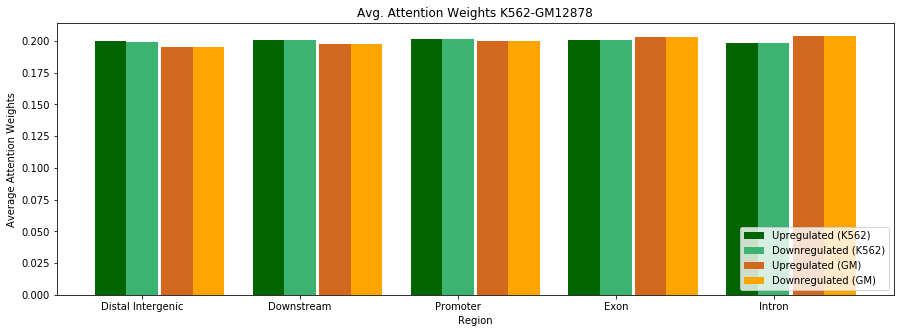

'\n# Plot Cutoff > 0 weights\nfig2, ax2 = plt.subplots(figsize = (10, 5))\nplt.bar(i, k562_att.loc[GMup_min["Gene"]].mean(axis = 0), color = \'b\', label = "K562", width = 0.2)\nplt.bar(i + bar_width, gm_att.loc[GMdown_min["Gene"]].mean(axis = 0), color = \'r\', label = "GM", width = 0.2)\n\nplt.xlabel("Region")\nplt.ylabel("Average Attention Weights")\nplt.title("Avg. Attention Weights K562-GM12878: Down")\nplt.xticks(i + bar_width, mod_5)\nplt.legend(loc = "lower right")\nplt.show()\n'

In [0]:
# up gm --> downregulated k562
mod_5 = ["Distal Intergenic", "Downstream", "Promoter", "Exon", "Intron"]
i = np.arange(len(mod_5))
bar_width = 0.2

# Plot Cutoff > 0 weights
fig1, ax1 = plt.subplots(figsize = (15, 5))
plt.bar(i, k562_att.loc[GMdown_min["Gene"]].mean(axis = 0), color = 'darkgreen', label = "Upregulated (K562)", width = 0.2)
plt.bar(i + bar_width, k562_att.loc[GMup_min["Gene"]].mean(axis = 0), color = 'mediumseagreen', label = "Downregulated (K562)", width = 0.2)
plt.bar(i + bar_width + 0.22, gm_att.loc[GMdown_min["Gene"]].mean(axis = 0), color = "chocolate", label = "Upregulated (GM)", width = 0.2)
plt.bar(i + bar_width + bar_width + 0.22, gm_att.loc[GMup_min["Gene"]].mean(axis = 0), color = 'orange', label = "Downregulated (GM)", width = 0.2)



plt.xlabel("Region")
plt.ylabel("Average Attention Weights")
plt.title("Avg. Attention Weights K562-GM12878")
plt.xticks(i + bar_width, mod_5)
plt.legend(loc = "lower right")
plt.savefig('drive/My Drive/COMS4995_Final/Initial_split/DeepDiffRuns/k562_gm_weights5.png')
plt.show()

'''
# Plot Cutoff > 0 weights
fig2, ax2 = plt.subplots(figsize = (10, 5))
plt.bar(i, k562_att.loc[GMup_min["Gene"]].mean(axis = 0), color = 'b', label = "K562", width = 0.2)
plt.bar(i + bar_width, gm_att.loc[GMdown_min["Gene"]].mean(axis = 0), color = 'r', label = "GM", width = 0.2)

plt.xlabel("Region")
plt.ylabel("Average Attention Weights")
plt.title("Avg. Attention Weights K562-GM12878: Down")
plt.xticks(i + bar_width, mod_5)
plt.legend(loc = "lower right")
plt.show()
'''

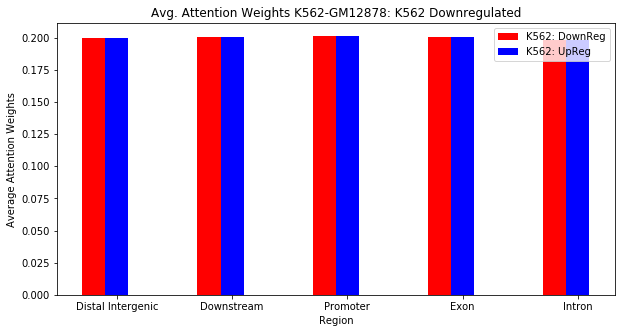

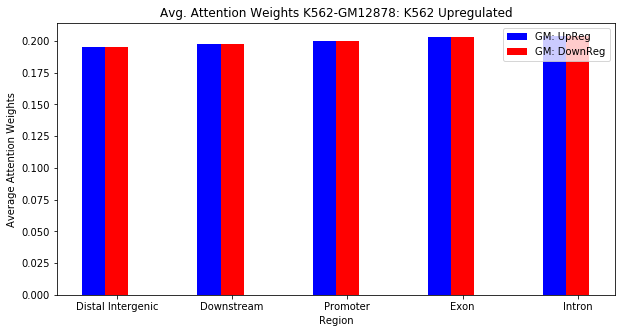

In [0]:
# up gm --> downregulated k562
mod_5 = ["Distal Intergenic", "Downstream", "Promoter", "Exon", "Intron"]
i = np.arange(len(mod_5))
bar_width = 0.2

# Plot Cutoff > 0 weights
fig1, ax1 = plt.subplots(figsize = (10, 5))
plt.bar(i, k562_att.loc[GMup_min["Gene"]].mean(axis = 0), color = 'r', label = "K562: DownReg", width = 0.2)
# plt.bar(i + bar_width, gm_att.loc[GMup_min["Gene"]].mean(axis = 0), color = 'r', label = "GM: UpReg", width = 0.2)
plt.bar(i + bar_width, k562_att.loc[GMdown_min["Gene"]].mean(axis = 0), color = 'b', label = "K562: UpReg", width = 0.2)


plt.xlabel("Region")
plt.ylabel("Average Attention Weights")
plt.title("Avg. Attention Weights K562-GM12878: K562 Downregulated")
plt.xticks(i + bar_width, mod_5)
plt.legend()
plt.show()

# Plot Cutoff > 0 weights
fig2, ax2 = plt.subplots(figsize = (10, 5))
# plt.bar(i, k562_att.loc[GMdown_min["Gene"]].mean(axis = 0), color = 'b', label = "K562: UpReg", width = 0.2)
plt.bar(i, gm_att.loc[GMup_min["Gene"]].mean(axis = 0), color = 'b', label = "GM: UpReg", width = 0.2)
plt.bar(i + bar_width, gm_att.loc[GMdown_min["Gene"]].mean(axis = 0), color = 'r', label = "GM: DownReg", width = 0.2)

plt.xlabel("Region")
plt.ylabel("Average Attention Weights")
plt.title("Avg. Attention Weights K562-GM12878: K562 Upregulated")
plt.xticks(i + bar_width, mod_5)
plt.legend()
plt.show()


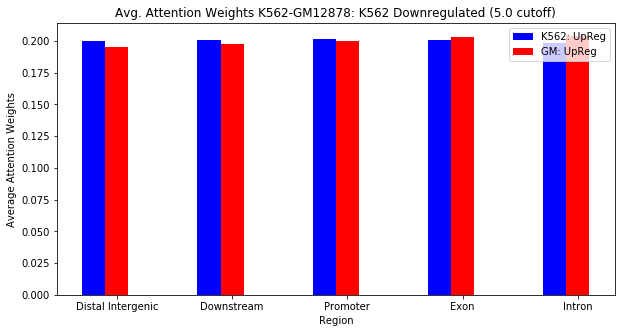

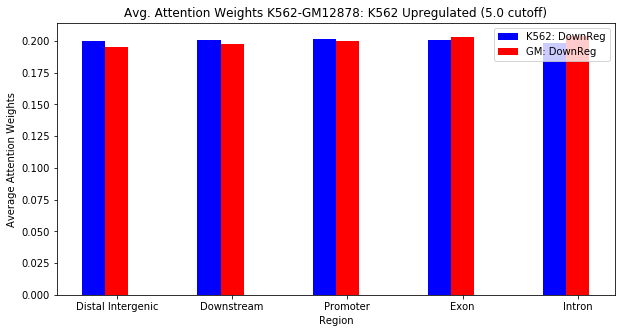

In [0]:
# Plot Cutoff > 5 weights
fig3, ax3 = plt.subplots(figsize = (10, 5))
plt.bar(i, k562_att.loc[GMdown_5["Gene"]].mean(axis = 0), color = 'b', label = "K562: UpReg", width = 0.2)
plt.bar(i + bar_width, gm_att.loc[GMup_5["Gene"]].mean(axis = 0), color = 'r', label = "GM: UpReg", width = 0.2)

plt.xlabel("Region")
plt.ylabel("Average Attention Weights")
plt.title("Avg. Attention Weights K562-GM12878: K562 Downregulated (5.0 cutoff)")
plt.xticks(i + bar_width, mod_5)
plt.legend()
plt.show()

# Plot Cutoff > 5 weights
fig4, ax4 = plt.subplots(figsize = (10, 5))
plt.bar(i, k562_att.loc[GMup_5["Gene"]].mean(axis = 0), color = 'b', label = "K562: DownReg", width = 0.2)
plt.bar(i + bar_width, gm_att.loc[GMdown_5["Gene"]].mean(axis = 0), color = 'r', label = "GM: DownReg", width = 0.2)

plt.xlabel("Region")
plt.ylabel("Average Attention Weights")
plt.title("Avg. Attention Weights K562-GM12878: K562 Upregulated (5.0 cutoff)")
plt.xticks(i + bar_width, mod_5)
plt.legend()
plt.show()


## HMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM ???